In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import fftpack
%pylab inline
plt.style.use('seaborn-whitegrid')
pylab.rcParams['figure.figsize'] = (22, 6)
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

Populating the interactive namespace from numpy and matplotlib


C:\Users\s158079\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'fftpack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
df = pd.read_csv('Data/BMS/Rooms and HVAC/RCU middenhal.csv', delimiter=';', encoding='utf-8')

In [3]:
df_temp = df[['Tijdstip', 'Gemiddelde ruimtetemp [°C] - RCU Middelhal 255 ()']]
df_temp.is_copy = False
df_temp.columns = ['Time', 'Temperature']

In [4]:
df_temp.is_copy = False
df_temp['Time'] = pd.to_datetime(df_temp['Time'], format="%d-%m-%Y %H:%M.%S")

df_temp['Temperature'] = [str(x).replace(',', '.') for x in df_temp['Temperature']]
df_temp['Temperature'] = pd.to_numeric(df_temp['Temperature'], errors='coerce')

In [5]:
df_temp.sort_values(['Time'], inplace=True)

In [6]:
df_temp = df_temp.loc[df_temp['Time'] > datetime.datetime(2017, 10, 23, 9, 0, 0)]
df_temp = df_temp.loc[df_temp['Time'] <= datetime.datetime(2018, 3, 8, 4, 52, 0)]

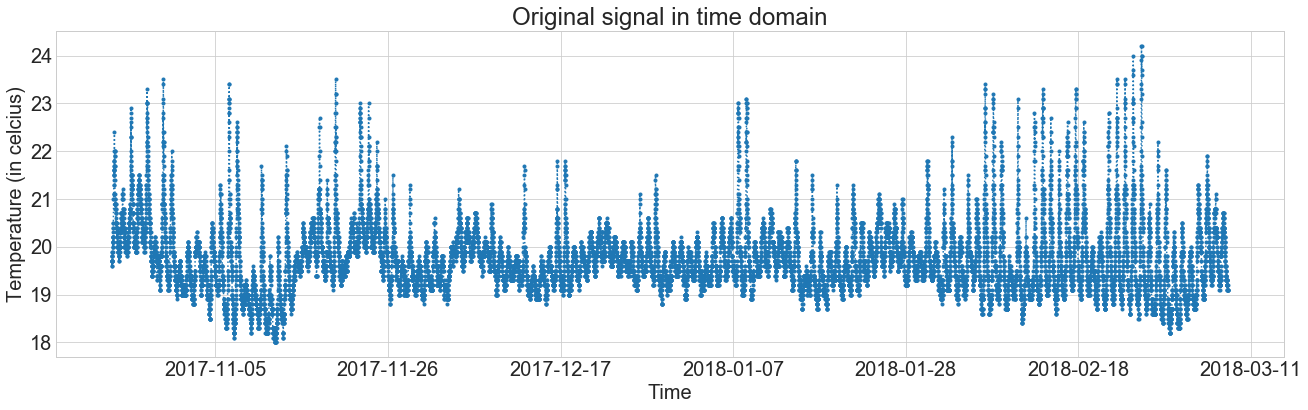

In [7]:
plt.plot(df_temp['Time'], df_temp['Temperature'], linestyle=':', marker='.')
plt.title('Original signal in time domain')
plt.xlabel('Time')
plt.ylabel('Temperature (in celcius)')
plt.show()

In [8]:
demean = lambda df: df - df.mean()
time = pd.DatetimeIndex(df_temp['Time'])
grouped = df_temp.groupby([time.year, time.month, time.day])

In [9]:
def normalize(row, mean):

    return (row - mean)/mean

def scale(row, mean):

    return (row - mean)

norm_df = pd.DataFrame()

for name, group in grouped:
    df_sub = pd.DataFrame(group)
    mean = df_sub['Temperature'].mean()

    df_sub['Temperature_normalized'] = df_sub.apply(lambda row: normalize(row['Temperature'], mean), axis=1)
    df_sub['Temperature_scaled'] = df_sub.apply(lambda row: scale(row['Temperature'], mean), axis=1)
    norm_df = norm_df.append(df_sub)

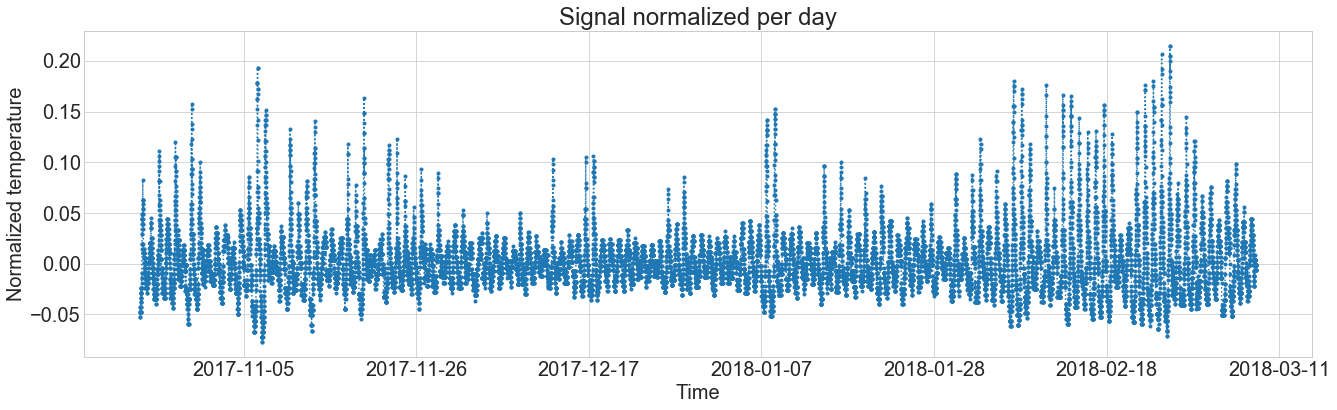

In [10]:
plt.plot(norm_df['Time'], norm_df['Temperature_normalized'], linestyle=':', marker='.')
plt.title('Signal normalized per day')
plt.ylabel('Normalized temperature')
plt.xlabel('Time')
plt.show()

In [11]:
X_temp_norm = np.fft.fft(norm_df['Temperature_normalized'])
X_temp_scaled = np.fft.fft(norm_df['Temperature_scaled'])

In [12]:
freqs_norm = np.fft.fftfreq(len(norm_df['Temperature_normalized'])) * (1/480)
freqs_scaled = np.fft.fftfreq(len(norm_df['Temperature_scaled'])) * (1/480)

Text(0.5,1,'DFT')

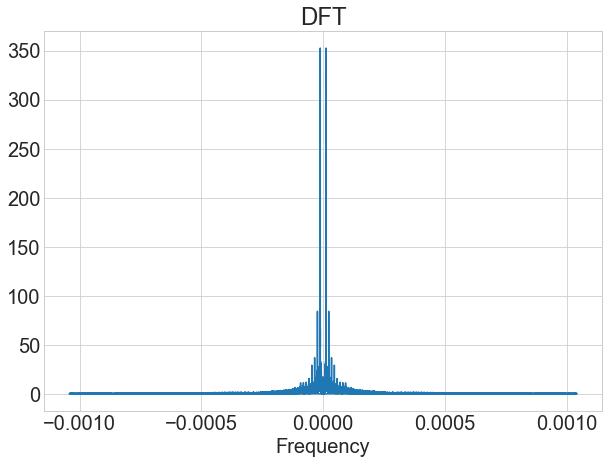

In [13]:
pylab.rcParams['figure.figsize'] = (10, 7)
plt.plot(freqs_norm, abs(X_temp_norm))
plt.xlabel('Frequency')
plt.title('DFT')

In [14]:
def dft_map(X, Fs, shift=True):
    resolution = float(Fs) / len(X)
    if shift:
        n, Y = dft_shift(X)
    else:
        Y = X
        n = np.arange(0, len(Y))
    f = n * resolution
    return f, Y

Text(0.5,1,'DFT')

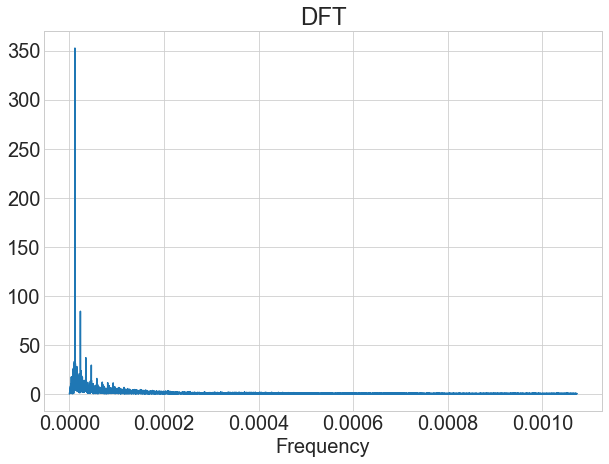

In [15]:
f, y = dft_map(X_temp_norm, 1/480, shift=False)
pylab.rcParams['figure.figsize'] = (10, 7)
plt.plot(f[:12587], abs(y[:12587]))
plt.xlabel('Frequency')
plt.title('DFT')

In [16]:
X_temp_norm_5 = [k  if abs(k) > 5 else 0 for k in X_temp_norm]
X_temp_norm_10 = [k  if abs(k) > 10 else 0 for k in X_temp_norm]
X_temp_norm_50 = [k  if abs(k) > 50 else 0 for k in X_temp_norm]
X_temp_norm_100 = [k  if abs(k) > 100 else 0 for k in X_temp_norm]
X_temp_norm_250 = [k  if abs(k) > 250 else 0 for k in X_temp_norm]

In [19]:
x_orig = np.fft.ifft(X_temp_norm)
x_reconstruct_5 = np.fft.ifft(X_temp_norm_5)
x_reconstruct_10 = np.fft.ifft(X_temp_norm_10)
x_reconstruct_50 = np.fft.ifft(X_temp_norm_50)
x_reconstruct_100 = np.fft.ifft(X_temp_norm_100)
x_reconstruct_250 = np.fft.ifft(X_temp_norm_250)

C:\Users\s158079\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


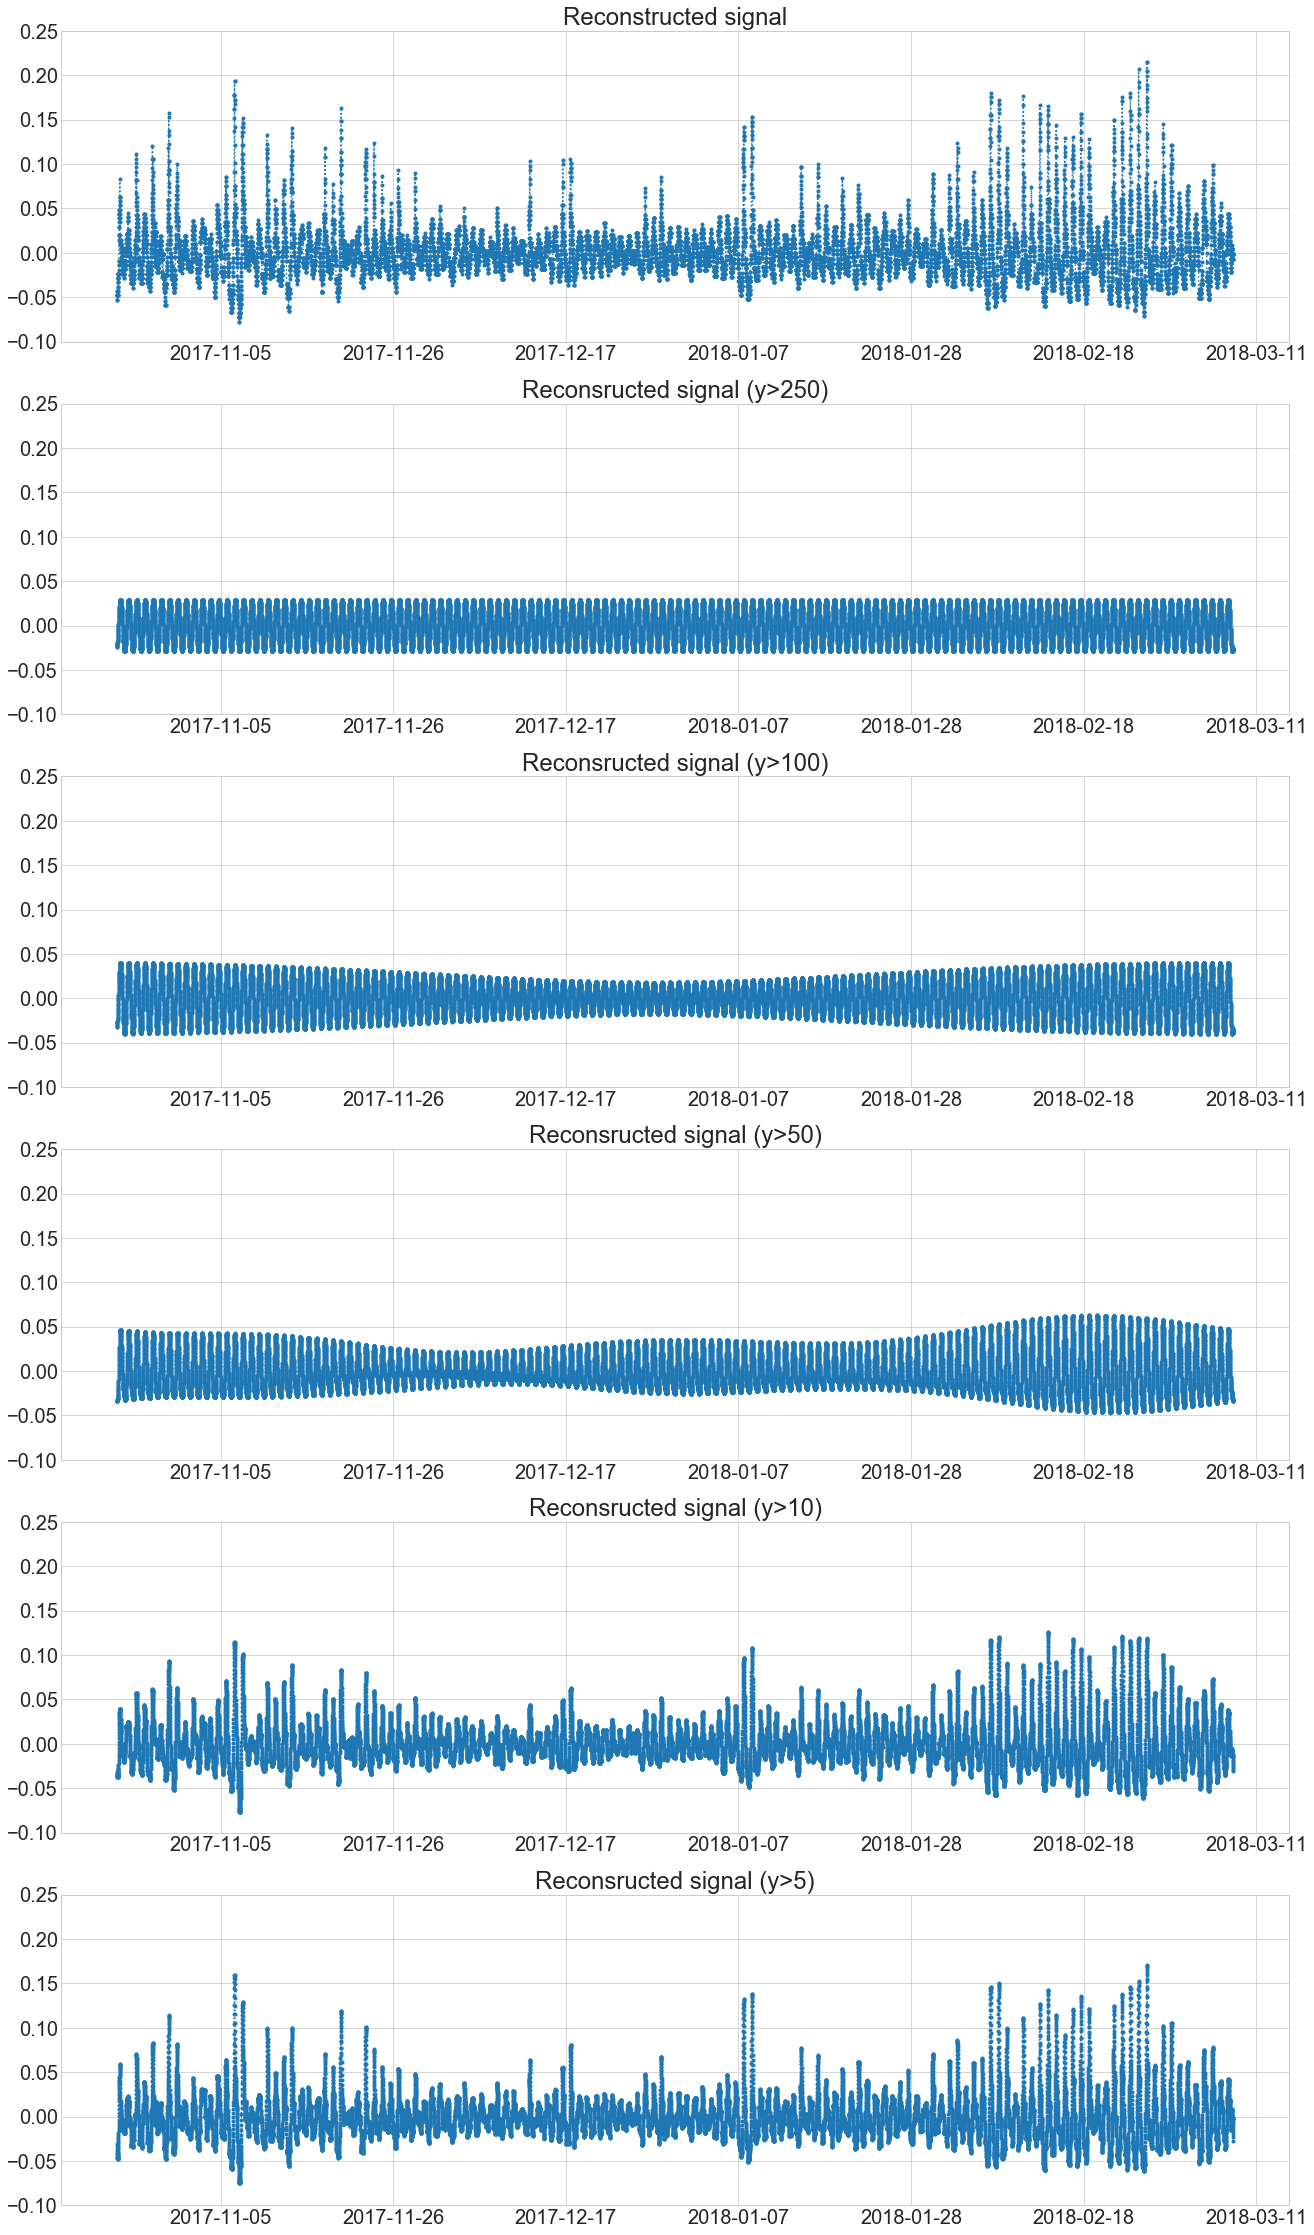

In [21]:
pylab.rcParams['figure.figsize'] = (22, 40)
plt.subplots_adjust(wspace=8)
plt.subplot(611)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconstructed signal')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], norm_df['Temperature_normalized'], linestyle=':', marker='.')

plt.subplot(612)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>250)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_250, linestyle=':', marker='.')

plt.subplot(613)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>100)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_100, linestyle=':', marker='.')

plt.subplot(614)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>50)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_50, linestyle=':', marker='.')

plt.subplot(615)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>10)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_10, linestyle=':', marker='.')

plt.subplot(616)
axes = plt.gca()
axes.set_ylim([-0.1, 0.25])
plt.title('Reconsructed signal (y>5)')
plt.xticks(rotation=0)
plt.plot(norm_df['Time'], x_reconstruct_5, linestyle=':', marker='.')

In [22]:
norm_df.sort_values(['Time'], inplace=True)
norm_df.reset_index(drop=True, inplace=True)

In [23]:
normalized_y =norm_df['Temperature_normalized'].rolling(window=180).mean()
normalized_y.fillna(0, inplace=True)

In [24]:
# pylab.rcParams['figure.figsize'] = (22, 8)
# plt.plot(normalized_y)

In [26]:
# new_t = [(m*480)/(60*60*24) for m in range(len(x_orig))]

In [27]:
# plt.plot(new_t, x_orig)